# Imports

In [3]:
# SETUP
## Importing libs
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Random params
np.random.seed(0)
random_state = 338

## Plot params
%matplotlib inline
np.random.seed(0)
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

## Load train and test
test = pd.read_csv('../test.csv', index_col='id')
dT = pd.read_csv('../train.csv', index_col='id')

## Calc stats
stats = dT.describe().copy()
statsTarget = stats.pop('claim')
stats = stats.transpose()

# Kolmogorov-Smirnov Distance

## Cálculo das distâncias

In [14]:
uns = dT.loc[dT['claim']==1].drop('claim',axis=1).copy()
zeros = dT.loc[dT['claim']==0].drop('claim',axis=1).copy()

print(dT.shape[0], ' = ', uns.shape[0]+zeros.shape[0])

957919  =  957919



 Intercambiáveis:
KstestResult(statistic=0.015097803425235035, pvalue=7.589370177478744e-48)
KstestResult(statistic=0.015097803425235035, pvalue=7.589370177478744e-48)

 Se comparar a mesma distribuição:
KstestResult(statistic=0.0, pvalue=1.0)
KstestResult(statistic=0.0, pvalue=1.0)


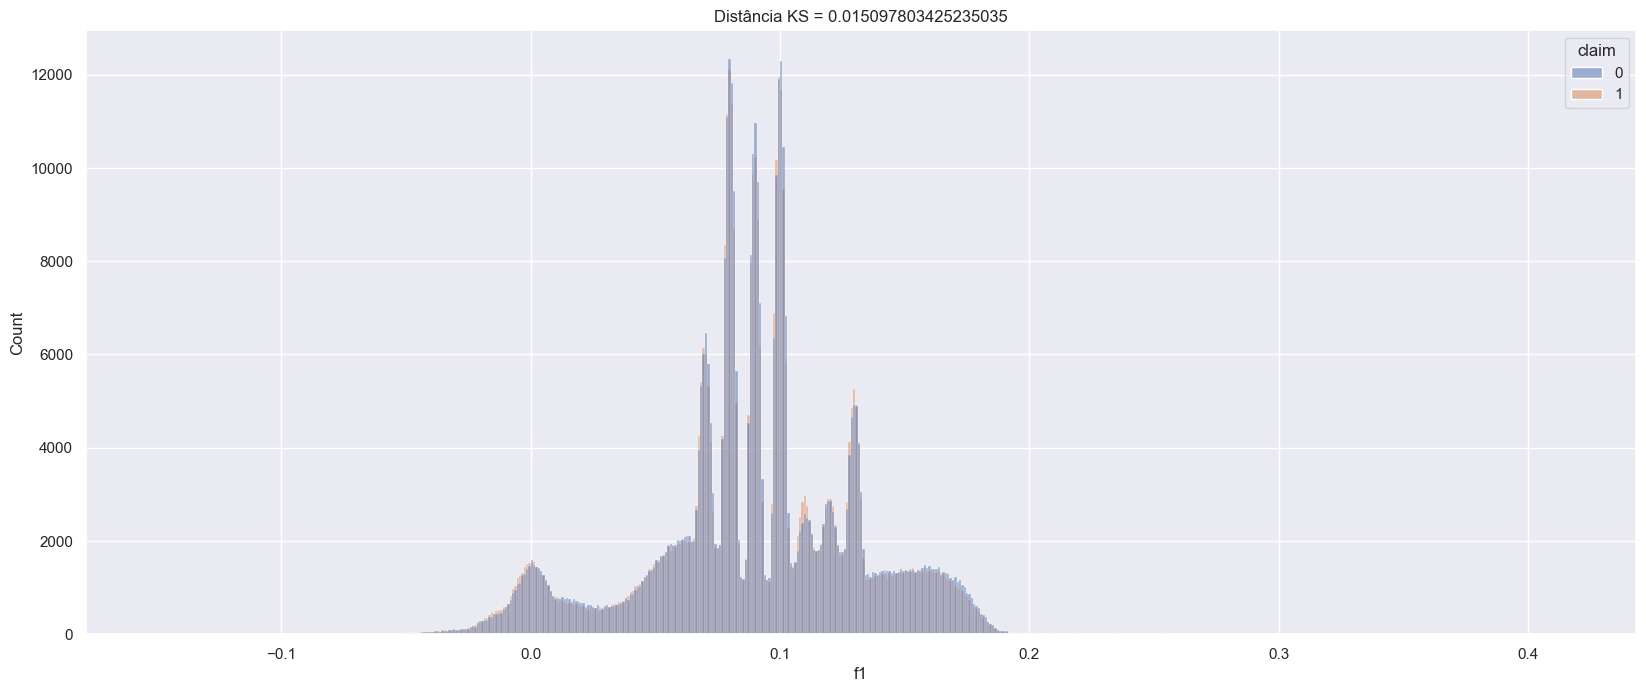

In [23]:
from scipy.stats import kstest

print('\n Intercambiáveis:')
print(kstest(uns['f1'], zeros['f1']))
print(kstest(zeros['f1'],uns['f1']))

print('\n Se comparar a mesma distribuição:')
print(kstest(zeros['f1'],zeros['f1']))
print(kstest(uns['f1'],uns['f1']))


# Visualizando as distribuições
sns.histplot(data = dT, x = 'f1', hue = 'claim');
titulo = 'Distância KS = '+str(kstest(zeros['f1'],uns['f1'])[0]);
plt.title(titulo);

In [30]:
from tqdm import tqdm

# Calculando para cada feature:
dists = []
pvals = []
feats = []

for feat in tqdm(dT.drop('claim',axis=1).columns):
    ksd,pval = kstest(uns[feat], zeros[feat])
    dists.append(ksd)
    pvals.append(pval)   
    feats.append(feat)

filtrando = pd.DataFrame({
    'dist': dists,
    'pval': pvals
})

filtrando.index = feats
filtrando.head()

100%|██████████| 118/118 [01:21<00:00,  1.45it/s]


,dist,pval
f1,0.015098,7.589370e-48
f2,0.014897,1.363162e-46
f3,0.022016,2.874251e-101
f4,0.016606,8.507246e-58
f5,0.015414,7.491464e-50


## Visualizando resultados

In [36]:
ksd_stats = filtrando.describe()
ksd_stats

,dist,pval
count,118.000000,1.180000e+02
mean,0.016849,2.369708e-48
std,0.001883,1.614886e-47
min,0.014897,1.390863e-116
25%,0.015610,1.478178e-64
50%,0.016006,1.010704e-53
75%,0.017567,4.039728e-51
max,0.023629,1.363162e-46


- p-valores baixos (alta confiança nos resultados)
- distancias aparentemente proximas, visualizar abaixo:

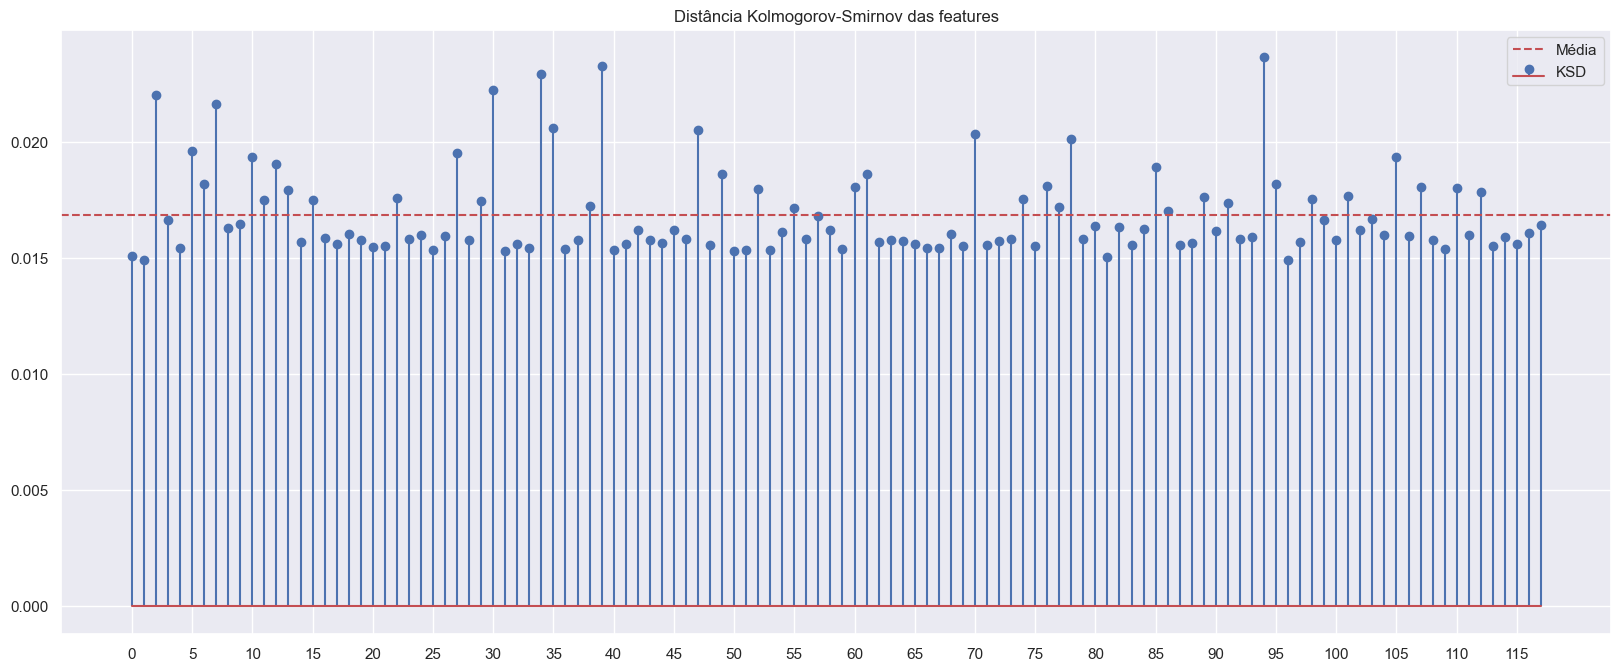

In [42]:
plt.stem(filtrando['dist']);
plt.axhline(ksd_stats.loc['mean','dist'],linestyle='--',color='r');
plt.legend(['Média','KSD']);
plt.title('Distância Kolmogorov-Smirnov das features');
plt.xticks(np.arange(0,len(filtrando['dist']),5));

## Treino de CATBOOST com filtro (KSD > Média => descarte): 0.771829 (Todos os dados => +/- 0.8004)

In [46]:
descartar = filtrando.loc[filtrando['dist']>ksd_stats.loc['mean','dist']].index.values
print(descartar)

['f3' 'f6' 'f7' 'f8' 'f11' 'f12' 'f13' 'f14' 'f16' 'f23' 'f28' 'f30' 'f31'
 'f35' 'f36' 'f39' 'f40' 'f48' 'f50' 'f53' 'f56' 'f61' 'f62' 'f71' 'f75'
 'f77' 'f78' 'f79' 'f86' 'f87' 'f90' 'f92' 'f95' 'f96' 'f99' 'f102' 'f106'
 'f108' 'f111' 'f113']


In [47]:
X = dT.drop(descartar, axis = 1).copy()
y = X.pop('claim')
X.head()

,f1,f2,f4,f5,f9,f10,f15,f17,f18,f19,...,f105,f107,f109,f110,f112,f114,f115,f116,f117,f118
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,0.017364,0.28915,3.992400e+14,86.489,-0.050305,8.6331,4.0607,26.8670,...,0.288010,0.001071,0.11093,-12.2280,1.90960,4378.80,1.2096,8.613400e+14,140.1,1.01770
1,0.10090,0.299610,0.276500,0.45970,3.874100e+15,9953.600,-0.019912,6.1872,1.0419,4.6404,...,0.340300,0.049276,0.97673,-56.7580,0.34808,913.23,1.2464,7.575100e+15,1861.0,0.28359
2,0.17803,-0.006980,0.272140,0.45948,1.224500e+13,15827.000,NaN,7.5463,1.9967,1.9526,...,0.084881,0.001668,0.20102,-5.7688,0.26290,45119.00,1.1764,3.218100e+14,3838.2,0.40690
3,0.15236,0.007259,0.025179,0.51947,7.781400e+13,-36.837,-0.106260,7.8490,1.0379,8.0030,...,0.260710,-0.002794,-0.01182,-34.8580,0.79631,4952.40,1.1784,4.533000e+12,4889.1,0.51486
4,0.11623,0.502900,0.297910,0.34490,1.907200e+15,144.120,NaN,7.2783,3.9757,NaN,...,0.238250,0.002208,0.92739,-13.6410,1.14640,3856.50,1.4830,-8.991300e+12,NaN,0.23049


In [49]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def avaliaModelo(X,y,modelo):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    modelo.fit(X_train,y_train,verbose=False,plot=True)

    print(roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]))

In [50]:
modelo_SELECTED = CatBoostClassifier(iterations=1000,task_type="GPU",devices='0:1', eval_metric='AUC')

print('\n ~ SELECTED AUGMENTED ~')
avaliaModelo(X,y,modelo_SELECTED)


 ~ SELECTED AUGMENTED ~


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7718299224905373


In [51]:
modelo_FULLDS = CatBoostClassifier(iterations=1000,task_type="GPU",devices='0:1', eval_metric='AUC')

print('\n ~ FULL ~')
X_full = dT.copy()
y_full = X_full.pop('claim')
avaliaModelo(X_full,y_full,modelo_FULLDS)


 ~ FULL ~


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7998439643786721


## Treino com filtro inverso (KSD <= Média => descarte): 0.71077

In [53]:
descartar2 = filtrando.loc[filtrando['dist']<=ksd_stats.loc['mean','dist']].index.values
print(descartar2)
X2 = dT.drop(descartar2, axis = 1).copy()
y2 = X2.pop('claim')
X2.head()

['f1' 'f2' 'f4' 'f5' 'f9' 'f10' 'f15' 'f17' 'f18' 'f19' 'f20' 'f21' 'f22'
 'f24' 'f25' 'f26' 'f27' 'f29' 'f32' 'f33' 'f34' 'f37' 'f38' 'f41' 'f42'
 'f43' 'f44' 'f45' 'f46' 'f47' 'f49' 'f51' 'f52' 'f54' 'f55' 'f57' 'f58'
 'f59' 'f60' 'f63' 'f64' 'f65' 'f66' 'f67' 'f68' 'f69' 'f70' 'f72' 'f73'
 'f74' 'f76' 'f80' 'f81' 'f82' 'f83' 'f84' 'f85' 'f88' 'f89' 'f91' 'f93'
 'f94' 'f97' 'f98' 'f100' 'f101' 'f103' 'f104' 'f105' 'f107' 'f109' 'f110'
 'f112' 'f114' 'f115' 'f116' 'f117' 'f118']


,f3,f6,f7,f8,f11,f12,f13,f14,f16,f23,...,f90,f92,f95,f96,f99,f102,f106,f108,f111,f113
id,,,,,,,,,,,,,,,,,,,,,
0,-37.566,-10.25100,135.12,168900.0,0.59881,1.423200e+09,0.27240,9.455600,1938.300,135.3200,...,3.8862,5252.100,0.66534,7768.900,2.2432,94569.0,0.097826,1.412400e+09,1.7482,-7.11570
1,11822.000,-0.83733,1721.90,119810.0,1.20930,3.334100e+09,0.28631,-0.012858,10.284,125.8100,...,13.3880,754.610,29.55000,7343.700,1.2708,6779.0,0.143370,1.903200e+09,4.1684,4.14200
2,907.270,0.17327,2298.00,360650.0,0.38164,1.230300e+09,0.25807,2.455600,26.873,1.6826,...,NaN,43.524,0.91948,47.915,3.4663,95531.0,0.032222,1.436500e+07,1.2042,8.13120
3,780.100,7.49140,112.51,259490.0,1.10960,1.223100e+09,0.30944,10.370000,533.840,92.1420,...,8.4211,2971.200,9.94050,12011.000,1.2261,373690.0,0.234240,1.442300e+09,2.0694,-16.33600
4,-109.150,-0.40932,2538.90,65332.0,1.05310,2.634100e+09,0.29782,2.654800,1808.900,96.7250,...,4.9662,-70.278,6.19120,197.470,1.0083,201300.0,0.141550,5.830700e+09,1.5298,-0.43124


In [55]:
modelo_SELECTED2 = CatBoostClassifier(iterations=1000,task_type="GPU",devices='0:1', eval_metric='AUC')

print('\n ~ SELECTED INVERSE ~')
avaliaModelo(X2,y2,modelo_SELECTED2)


 ~ SELECTED INVERSE ~


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7107657023871695


# Cross-entropy:

# Coefficient of Variation $ \lVert \frac{\sigma}{\mu} \rVert $ 

## Cálculo: